In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import gc
import matplotlib.pyplot as plt
import seaborn as sns

np.random.seed(123)
%matplotlib inline

pal = sns.color_palette()

print('# File sizes')
for f in os.listdir('data'):
    if 'zip' not in f:
        print(f.ljust(30) + str(round(os.path.getsize('data/' + f) / 1000000, 2)) + 'MB')


# File sizes
test.csv                      3.0MB
train.csv                     3.0MB
sample_submission.csv         0.0MB


In [2]:
df_train = pd.read_csv('data/train.csv')
print('Size of training set: {} rows and {} columns'.format(*df_train.shape))
df_train.head()

Size of training set: 4209 rows and 378 columns


,ID,y,X0,X1,X2,X3,X4,X5,X6,X8,...,X375,X376,X377,X378,X379,X380,X382,X383,X384,X385
0,0,130.81,k,v,at,a,d,u,j,o,...,0,0,1,0,0,0,0,0,0,0
1,6,88.53,k,t,av,e,d,y,l,o,...,1,0,0,0,0,0,0,0,0,0
2,7,76.26,az,w,n,c,d,x,j,x,...,0,0,0,0,0,0,1,0,0,0
3,9,80.62,az,t,n,f,d,x,l,e,...,0,0,0,0,0,0,0,0,0,0
4,13,78.02,az,v,n,f,d,h,d,n,...,0,0,0,0,0,0,0,0,0,0


Just from this, we can see that our training data is made up of just 4000 rows, but has 400 seemingly anonymised features inside. As well as this, we are given an ID (which is not equal to the row number, this could be significant) and the target value, which is the number of seconds taken. 

Let's start off by looking at the distribution of the target value:

min: 72.11 max: 265.32 mean: 100.669318128 std: 12.6778749695
Count of values above 180: 1


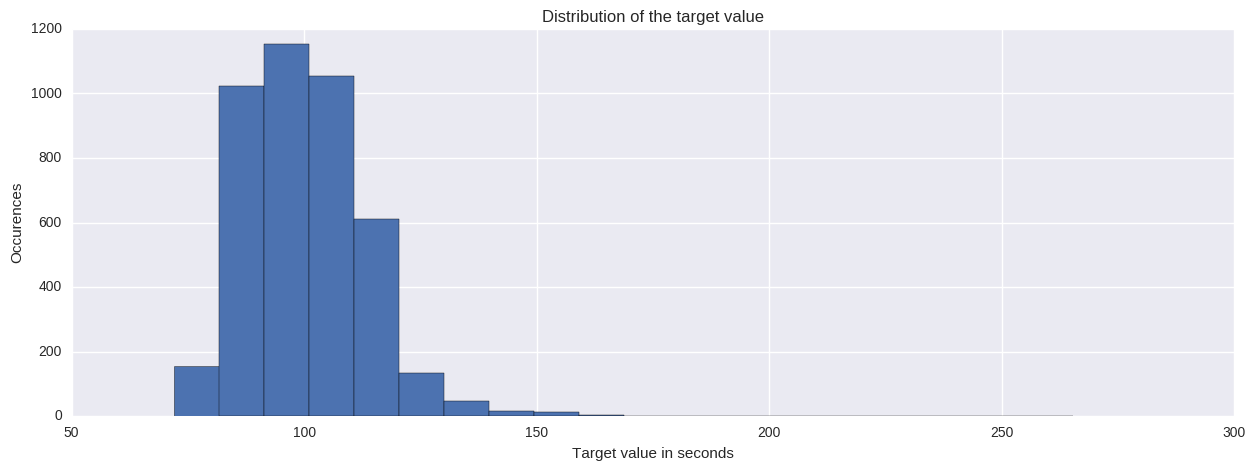

In [3]:
y_train = df_train['y'].values
plt.figure(figsize=(15, 5))
plt.hist(y_train, bins=20)
plt.xlabel('Target value in seconds')
plt.ylabel('Occurences')
plt.title('Distribution of the target value')

print('min: {} max: {} mean: {} std: {}'.format(min(y_train), max(y_train), y_train.mean(), y_train.std()))
print('Count of values above 180: {}'.format(np.sum(y_train > 180)))

So we have a pretty standard distribution here, which is centred around almost exactly 100. Nothing special to note here, except there is a single outlier at 265 seconds where every other value is below 180.

The fact that our ID is not equal to the row ID seems to suggest that the train and test sets were randomly sampled from the same dataset, which could have some special order to it, for example a time series. 

Let's take a look at how this target value changes over time in order to understand whether we're given time series data.

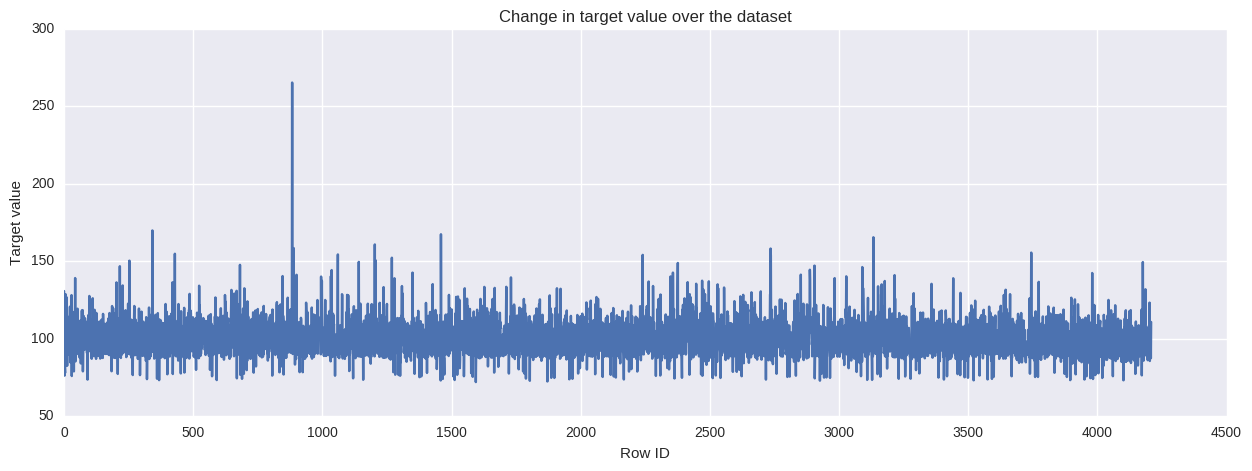

()
()


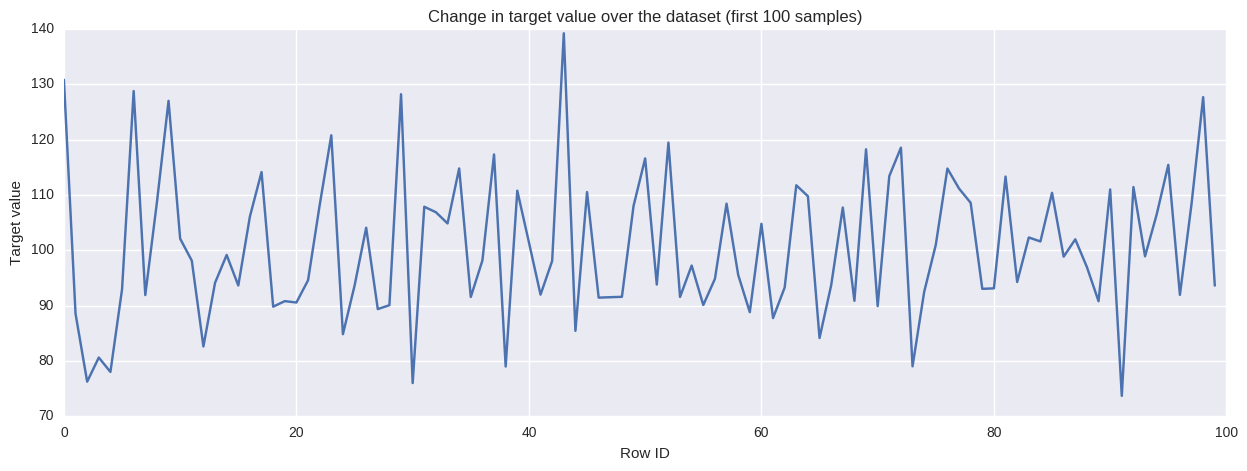

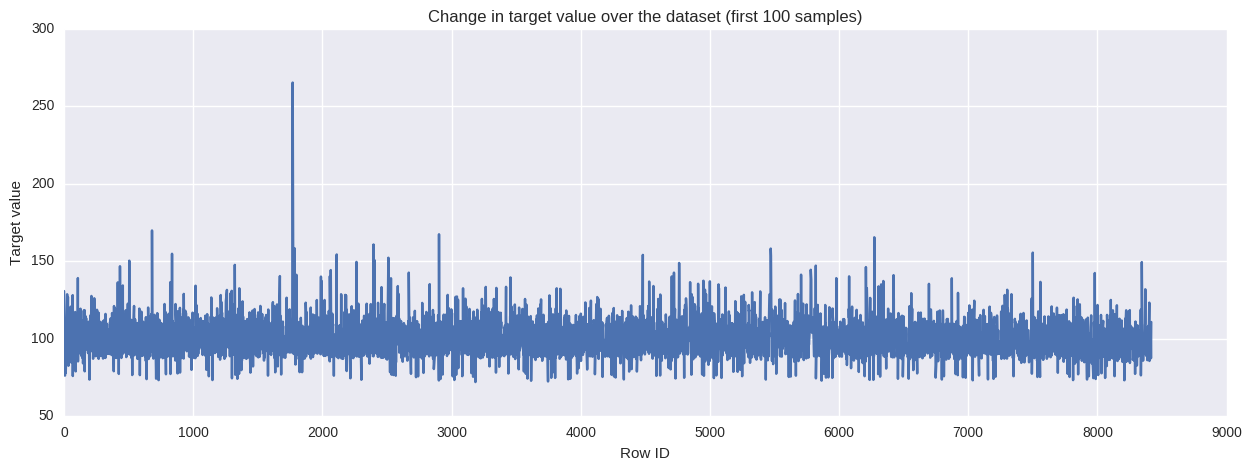

In [4]:
plt.figure(figsize=(15, 5))
plt.plot(y_train)
plt.xlabel('Row ID')
plt.ylabel('Target value')
plt.title('Change in target value over the dataset')
plt.show()

plt.figure(figsize=(15, 5))
plt.plot(y_train[:100])
plt.xlabel('Row ID')
plt.ylabel('Target value')
plt.title('Change in target value over the dataset (first 100 samples)')
print()

plt.figure(figsize=(15, 5))
plt.plot(df_train['ID'],df_train['y'])
plt.xlabel('Row ID')
plt.ylabel('Target value')
plt.title('Change in target value over the dataset (first 100 samples)')
print()

At first glance, there doesn't seem to be anything overly suspicious here - looks like how a random sort would. I might take a closer look later but for now let's move on to the features.


In [5]:
cols = [col for col in df_train.columns if 'X' in col]
print "num cols %d"%len(cols)
print
print "Feature Types"
df_train[cols].dtypes.value_counts()

num cols 376

Feature Types


int64     368
object      8
dtype: int64

So out of all our features, we are given 8 object (likely a string) variables, 368 integer variables. What about the cardinality of our features?

In [6]:
counts = [[], [], []]
for c in cols:
    col_type = df_train[c].dtype
    num_uniq = len(np.unique(df_train[c]))
    if num_uniq == 1: counts[0].append(c)
    elif num_uniq == 2 and col_type == np.int64: counts[1].append(c)
    else: counts[2].append(c)

print('Constant features: {} Binary features: {} Categorical features: {}\n'.format(*[len(c) for c in counts]))

print('Constant features:', counts[0])
print('Categorical features:', counts[2])

Constant features: 12 Binary features: 356 Categorical features: 8

('Constant features:', ['X11', 'X93', 'X107', 'X233', 'X235', 'X268', 'X289', 'X290', 'X293', 'X297', 'X330', 'X347'])
('Categorical features:', ['X0', 'X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X8'])


Interestingly, we have 12 features which only have a single value in them - these are pretty useless for supervised algorithms, and should probably be dropped (unless you want to use them for anomaly detection in case a different value appears in the test set)
The rest of our dataset is made up of many binary features, and a few categorical features.

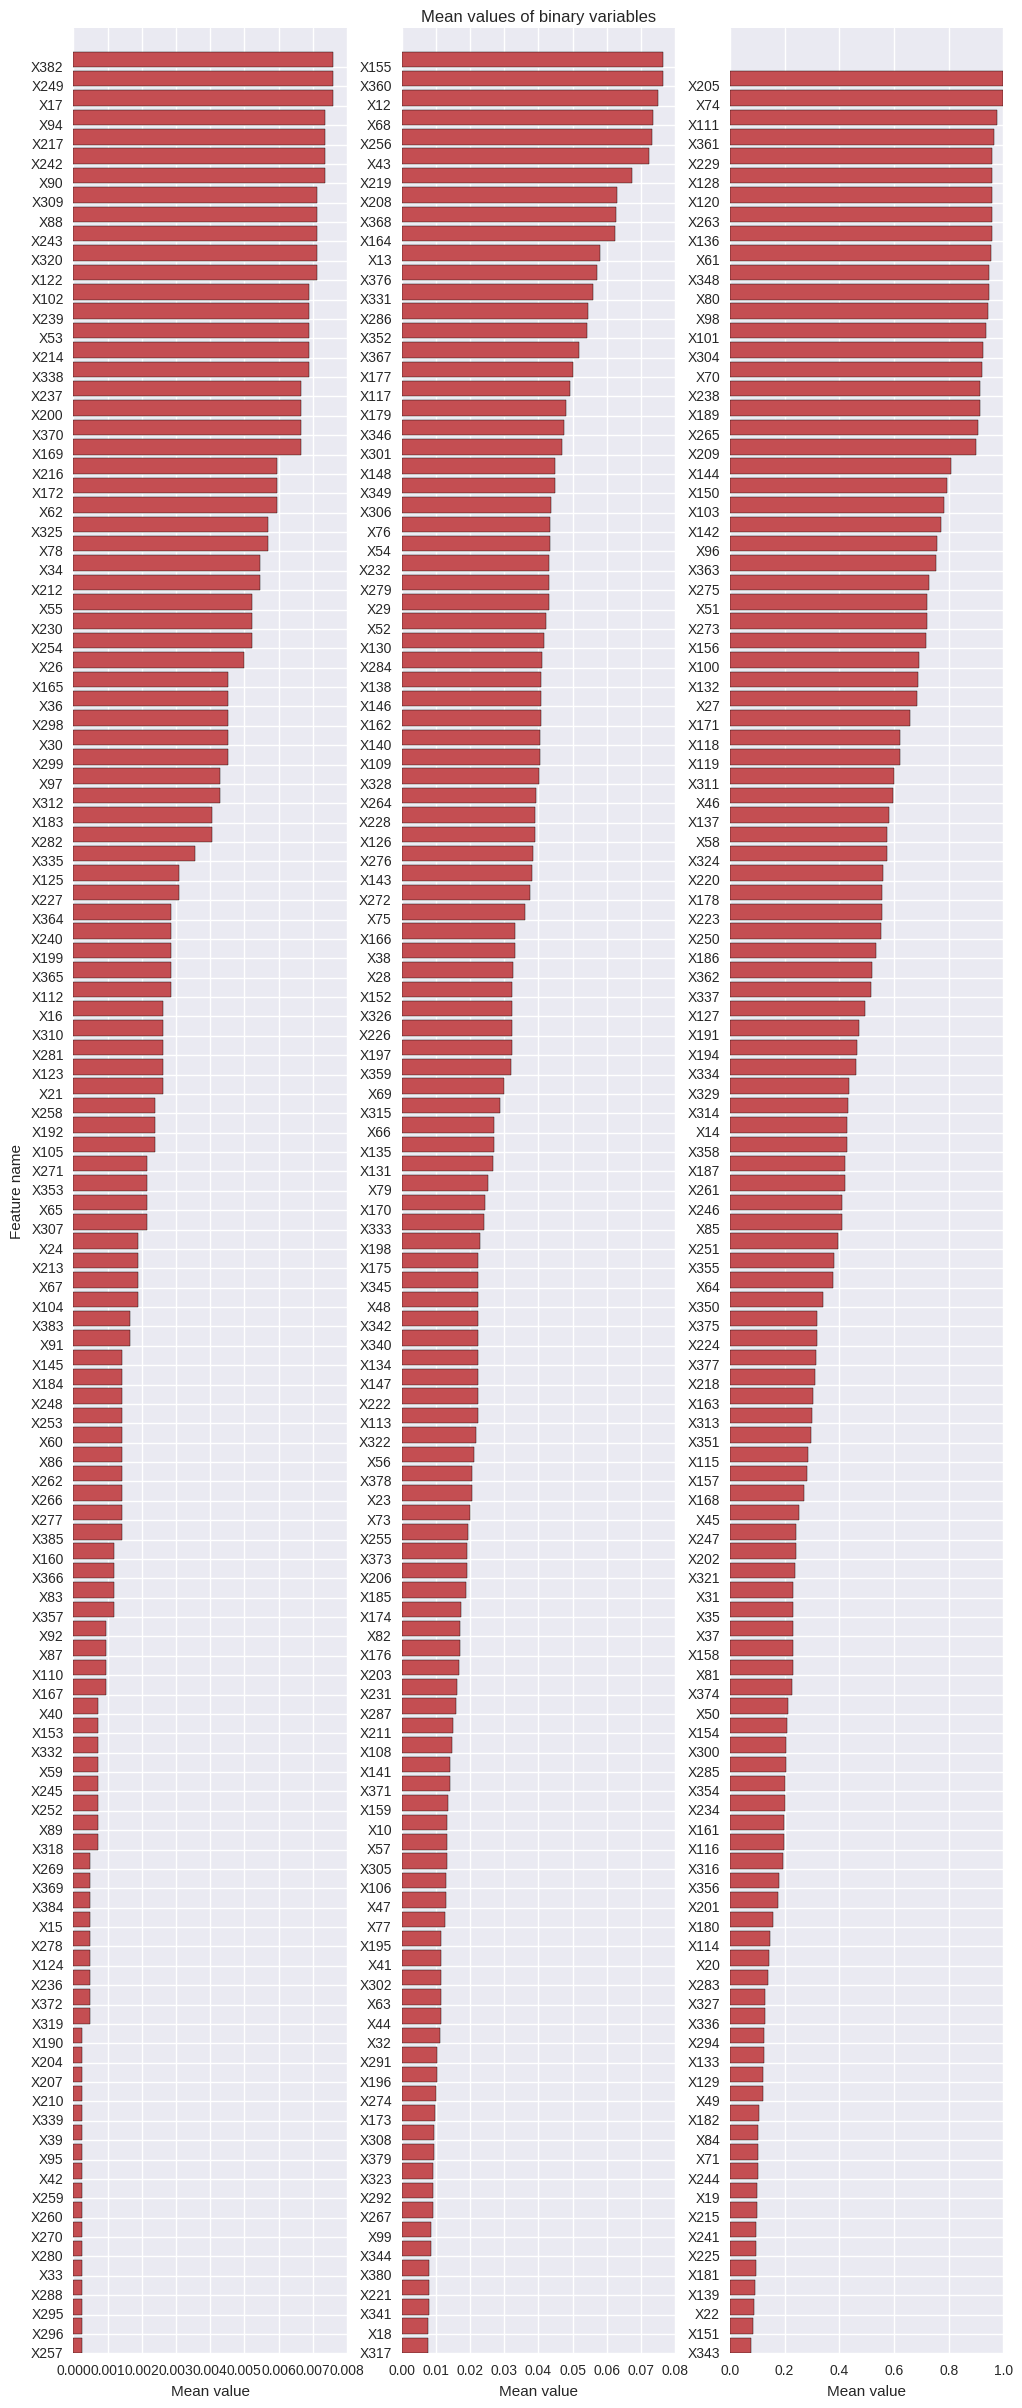

In [7]:
binary_means = [np.mean(df_train[c]) for c in counts[1]]
binary_names = np.array(counts[1])[np.argsort(binary_means)]
binary_means = np.sort(binary_means)

fig, ax = plt.subplots(1, 3, figsize=(12,30))
ax[0].set_ylabel('Feature name')
ax[1].set_title('Mean values of binary variables')
for i in range(3):
    names, means = binary_names[i*119:(i+1)*119], binary_means[i*119:(i+1)*119]
    ax[i].barh(range(len(means)), means, color=pal[2])
    ax[i].set_xlabel('Mean value')
    ax[i].set_yticks(range(len(means)))
    ax[i].set_yticklabels(names, rotation='horizontal')
plt.show()


In [8]:
#understannding how result of value_counts_() is organized
print df_train['X0'].value_counts()

z     360
ak    349
y     324
ay    313
t     306
x     300
o     269
f     227
n     195
w     182
j     181
az    175
aj    151
s     106
ap    103
h      75
d      73
al     67
v      36
af     35
ai     34
m      34
e      32
ba     27
at     25
a      21
ax     19
am     18
aq     18
i      18
u      17
l      16
aw     16
ad     14
b      11
au     11
k      11
r      10
as     10
bc      6
ao      4
c       3
aa      2
q       2
g       1
ac      1
ab      1
Name: X0, dtype: int64


In [9]:
#understanding how result of value_counts_() is organized
print df_train['X0'].value_counts().values

[360 349 324 313 306 300 269 227 195 182 181 175 151 106 103  75  73  67
  36  35  34  34  32  27  25  21  19  18  18  18  17  16  16  14  11  11
  11  10  10   6   4   3   2   2   1   1   1]


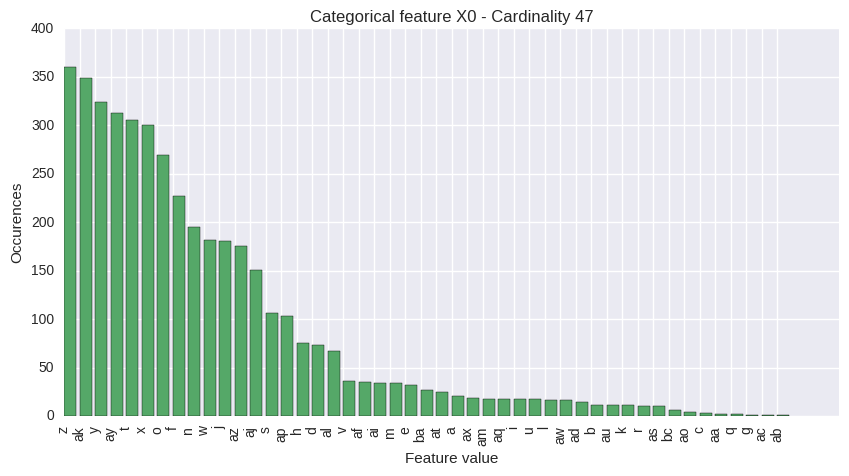

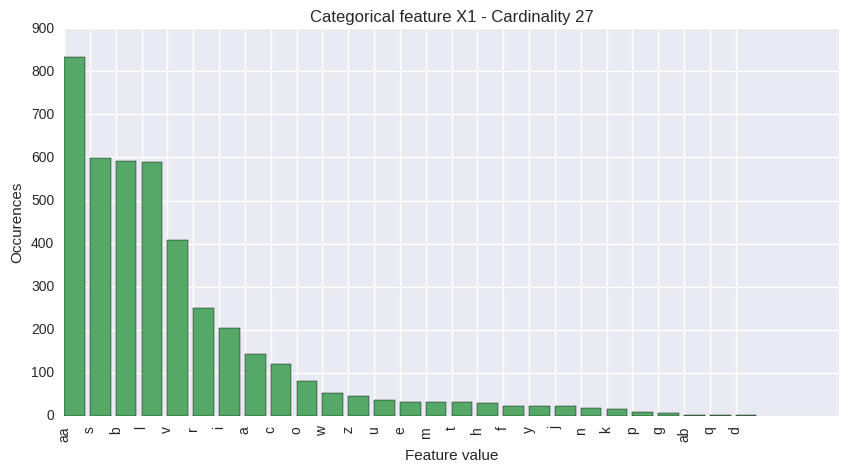

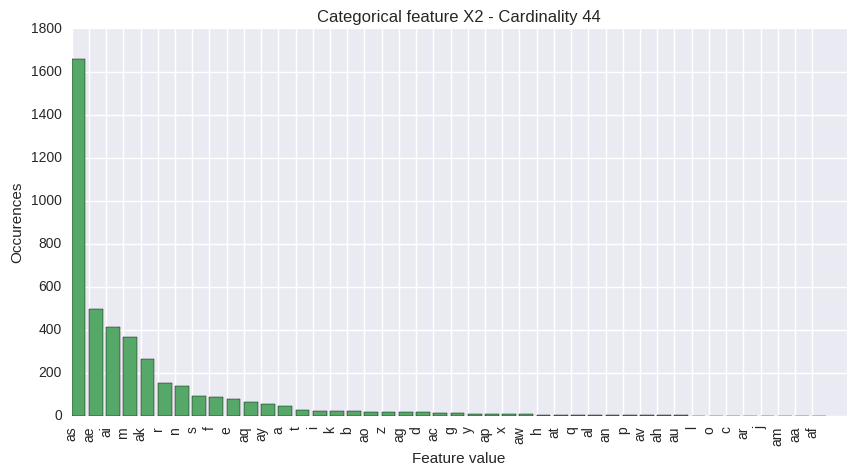

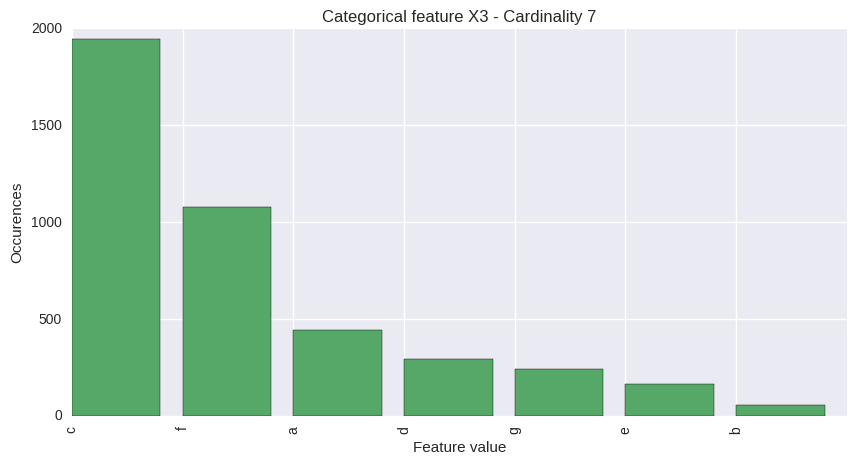

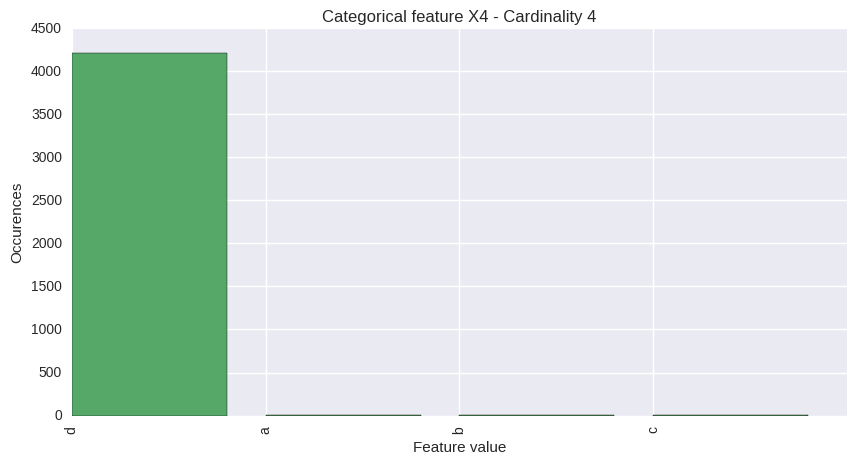

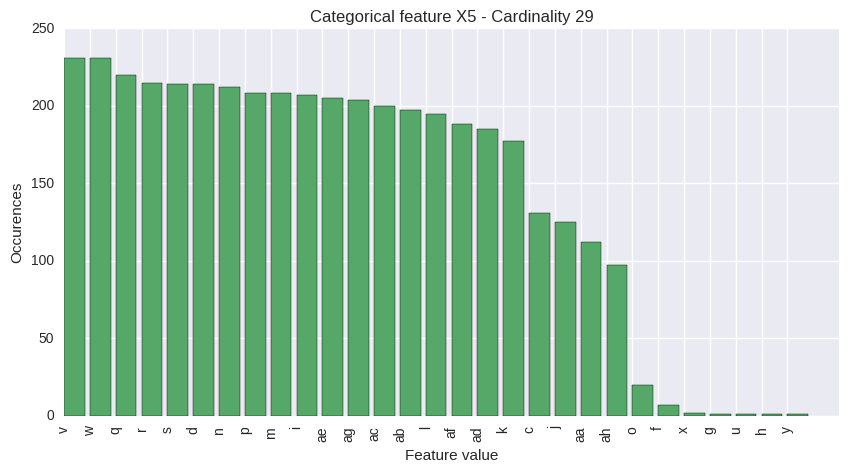

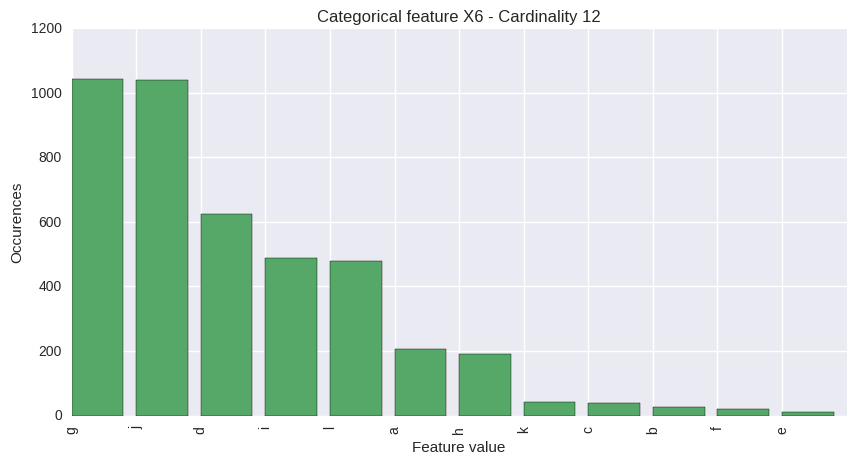

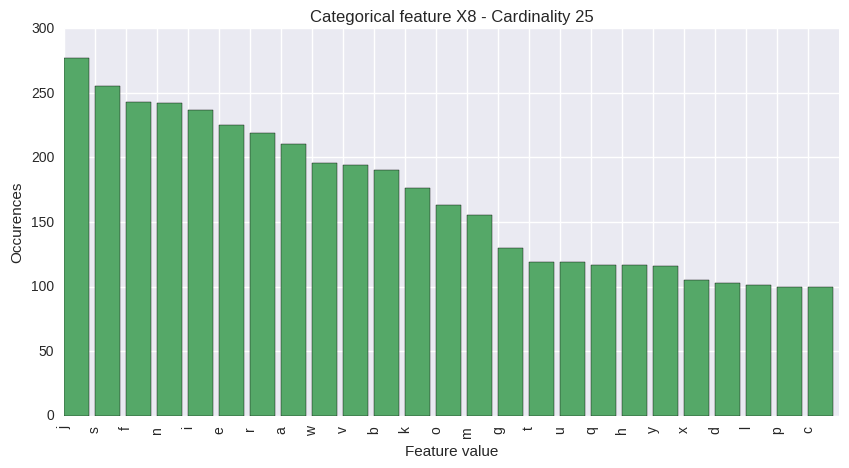

In [10]:
for c in counts[2]:
    value_counts = df_train[c].value_counts()
    fig, ax = plt.subplots(figsize=(10, 5))
    plt.title('Categorical feature {} - Cardinality {}'.format(c, len(np.unique(df_train[c]))))
    plt.xlabel('Feature value')
    plt.ylabel('Occurences')
    plt.bar(range(len(value_counts)), value_counts.values, color=pal[1])
    ax.set_xticks(range(len(value_counts)))
    ax.set_xticklabels(value_counts.index, rotation='vertical')
    plt.show()

## XGBoost Starter.
Now that we know the outline of what the data's made up of, we can make a simple model on it. Time to bring out XGBoost!

In [11]:
df_test = pd.read_csv('data/test.csv')

features = list(set(df_train.columns) - set(['ID', 'y']))

y_train = df_train['y'].values
id_test = df_test['ID'].values

x_train = df_train[features]
x_test = df_test[features]

for column in features:
    cardinality = len(np.unique(x_train[column]))
    if cardinality == 1:
        x_train.drop(column, axis=1) # Column with only one value is useless so we drop it
        x_test.drop(column, axis=1)
    if cardinality > 2: # Column is categorical
        mapper = lambda x: sum([ord(digit) for digit in x])
        x_train[column] = x_train[column].apply(mapper)
        x_test[column] = x_test[column].apply(mapper)
        
x_train.head()

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,X189,X185,X184,X187,X186,X181,X180,X183,X182,X291,...,X96,X97,X98,X99,X204,X205,X202,X203,X200,X201
0,1,0,1,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,1,0,0,1,0,0,0,0,0,0,...,1,0,1,0,0,1,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,1,0,1,0,0,1,0,0,0,0
3,0,0,0,0,0,0,0,0,0,1,...,1,0,1,0,0,1,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,1,0,1,0,0,1,0,0,0,0


In [24]:
import xgboost as xgb
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.2, random_state=123)

d_train = xgb.DMatrix(x_train, label=y_train)
d_valid = xgb.DMatrix(x_valid, label=y_valid)
d_test = xgb.DMatrix(x_test)

params = { 'objective': 'reg:linear',
           'eta': 0.01,
           'max_depth': 7,
           'num_threads':1,
           'lambda' : 3,
           'min_child_weight' : 2,
            'subsample' : 0.7,
           'n_trees': 1000
           #'booster': 'gblinear'
           
        }
num_round = 2000

def xgb_r2_score(preds, dtrain):
    labels = dtrain.get_label()
    return 'r2', r2_score(labels, preds)

watchlist = [(d_train, 'train'), (d_valid, 'valid')]

clf = xgb.train(params, d_train, num_round, watchlist, early_stopping_rounds=500, feval=xgb_r2_score, maximize=True, verbose_eval=50)

[0]	train-r2:-61.6767	valid-r2:-80.3077
Multiple eval metrics have been passed: 'valid-r2' will be used for early stopping.

Will train until valid-r2 hasn't improved in 500 rounds.
[50]	train-r2:-22.7945	valid-r2:-28.8088
[100]	train-r2:-8.25961	valid-r2:-10.1697
[150]	train-r2:-2.81044	valid-r2:-3.24351
[200]	train-r2:-0.745179	valid-r2:-0.698187
[250]	train-r2:0.056434	valid-r2:0.199522
[300]	train-r2:0.40748	valid-r2:0.515327
[350]	train-r2:0.583462	valid-r2:0.620199
[400]	train-r2:0.685803	valid-r2:0.64838
[450]	train-r2:0.750053	valid-r2:0.653971
[500]	train-r2:0.792058	valid-r2:0.646165
[550]	train-r2:0.822214	valid-r2:0.634845
[600]	train-r2:0.845403	valid-r2:0.626141
[650]	train-r2:0.865452	valid-r2:0.615383
[700]	train-r2:0.88277	valid-r2:0.609125
[750]	train-r2:0.89636	valid-r2:0.600197
[800]	train-r2:0.90807	valid-r2:0.593538
[850]	train-r2:0.918524	valid-r2:0.584312
[900]	train-r2:0.926874	valid-r2:0.577198
Stopping. Best iteration:
[437]	train-r2:0.735003	valid-r2:0.65462

In [13]:
p_test = clf.predict(d_test)

sub = pd.DataFrame()
sub['ID'] = id_test
sub['y'] = p_test
sub.to_csv('xgb.csv', index=False)

In [14]:
sub.count()

ID    4209
y     4209
dtype: int64